In [1]:
# Importar TensorFlow e NumPy
import tensorflow as tf
import numpy as np

# Importar a Sionna
try:
    import sionna as sn
except ImportError as e:
    # Instala a Sionna se o pacote ja não estiver instalado
    import os
    os.system("pip install sionna")
    import sionna as sn

# Para a plotagem
%matplotlib inline

import matplotlib.pyplot as plt

# Para medir performance
import time

# Para implementação das camadas Keras
from tensorflow.keras import Model

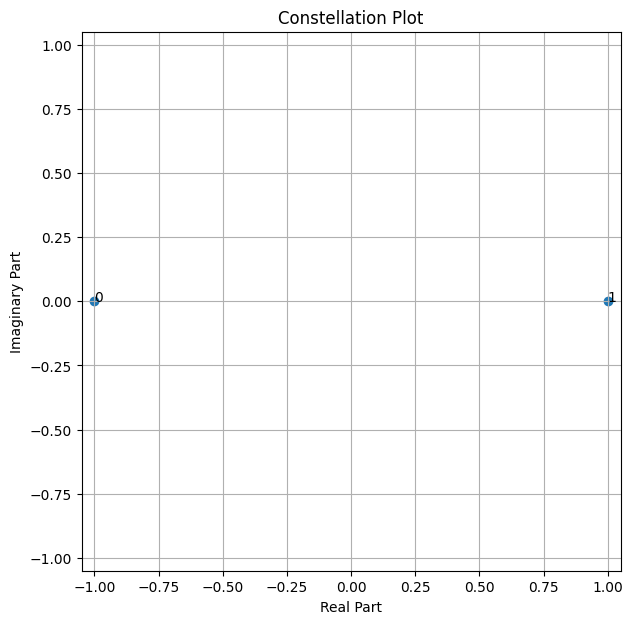

In [2]:
# Números de bits por símbolo 2^n (bpsk)
NBPS = 1 
# Define a constelação, np.array define pontos do plano na constelação e deve ter a mesma quantidade de pontos que 2^n.
constellation = sn.mapping.Constellation("custom", NBPS, np.array([-1,1]) )

constellation.show();

In [3]:
# Usamos a função mapper para designar os bits às suas respectivas posições na constelação
mapper = sn.mapping.Mapper(constellation=constellation)

# O demapper usa a mesma constelação do mapper.
demapper = sn.mapping.Demapper("app", constellation=constellation)
# A Sionna possui um comando para fornecer amostras uniformes de bits.
binary_source = sn.utils.BinarySource()
# Agora adicionamos um canal AWGN
awgn_channel = sn.channel.AWGN()
# A biblioteca também possui uma função que computa a densidade espectral de potência do ruído e a sua relação com a energia dos bits (eb/no) em db's.



no = sn.utils.ebnodb2no(ebno_db=10.0,num_bits_per_symbol=NBPS,coderate=1.0)


# Coderate é configurado com o valor 1 pois essa transmissão não tem codificação., mudar o eb_no muda o SNR e muda o resultado da modulação do sinal recebido, quanto maior for o ebno_db, mais clara é a transmissão. 
######################################################################
BATCH_SIZE = 64 # Quantidade de exemplos a serem processados em paralelo
bits = binary_source([BATCH_SIZE,1024]) # Blocklength
print("Shape of bits: ", bits.shape)
x = mapper(bits)
print("Shape of x: ", x.shape)
y = awgn_channel([x, no])
print("Shape of y: ", y.shape)
llr = demapper([y, no])
print("Shape of llr: ", llr.shape)
######################################################################
# Agora nós amostramos os bits recebidos e suas possições na constelação

num_amostras = 8 # Quantas amostras serão feitas
num_symbols = int(num_amostras/NBPS)

print(f"Primeiros {num_amostras} bits transmitidos: {bits[0,:num_amostras]}")
print(f"Primeiros {num_symbols} símbolos transmitidos: {np.round(x[0,:num_symbols], 2)}")
print(f"Primeiros {num_symbols} símbolos recebidos: {np.round(y[0,:num_symbols], 2)}")
print(f"Primeiros {num_amostras} demapped llrs: {np.round(llr[0,:num_amostras], 2)}")

Shape of bits:  (64, 1024)
Shape of x:  (64, 1024)
Shape of y:  (64, 1024)
Shape of llr:  (64, 1024)
Primeiros 8 bits transmitidos: [1. 1. 0. 0. 0. 0. 0. 1.]
Primeiros 8 símbolos transmitidos: [ 1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j]
Primeiros 8 símbolos recebidos: [ 0.57+0.25j  1.41-0.31j -0.97+0.14j -1.37+0.3j  -1.02+0.08j -0.99+0.32j
 -0.96-0.36j  1.49+0.35j]
Primeiros 8 demapped llrs: [ 22.79  56.52 -38.76 -54.8  -40.97 -39.49 -38.49  59.41]


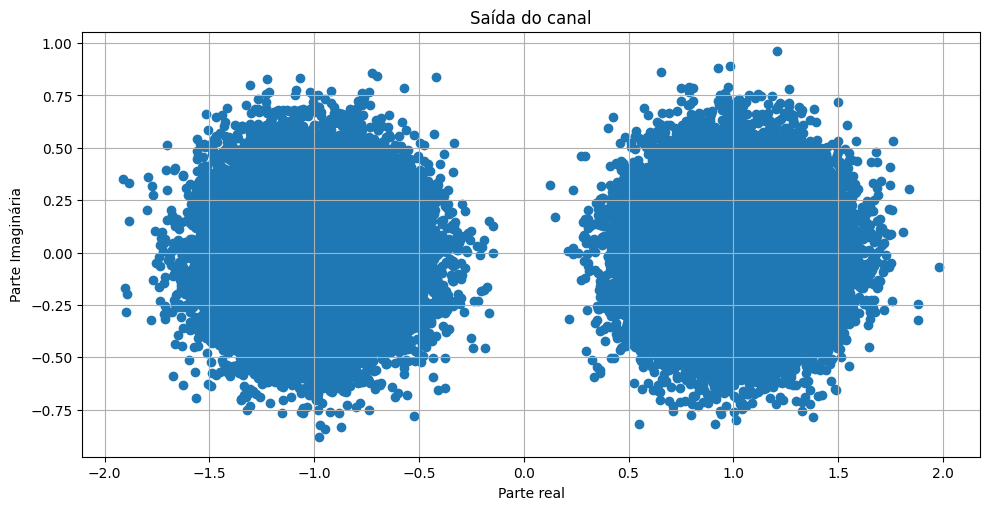

In [4]:
# Por último, visualizamos as amostrar com ruídos

plt.figure(figsize=(10,10))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Saída do canal')
plt.xlabel('Parte real')
plt.ylabel('Parte Imaginária') # Não irá haver parte imaginária pois se trata de uma transmissão em bpsk
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()